In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/var/folders/cl/wqxhc67j255bdr0rmv_bl3580000gn/T/ipykernel_97031/2709791818.py:17: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_combined['average'] = df_combined.mean(axis=1)


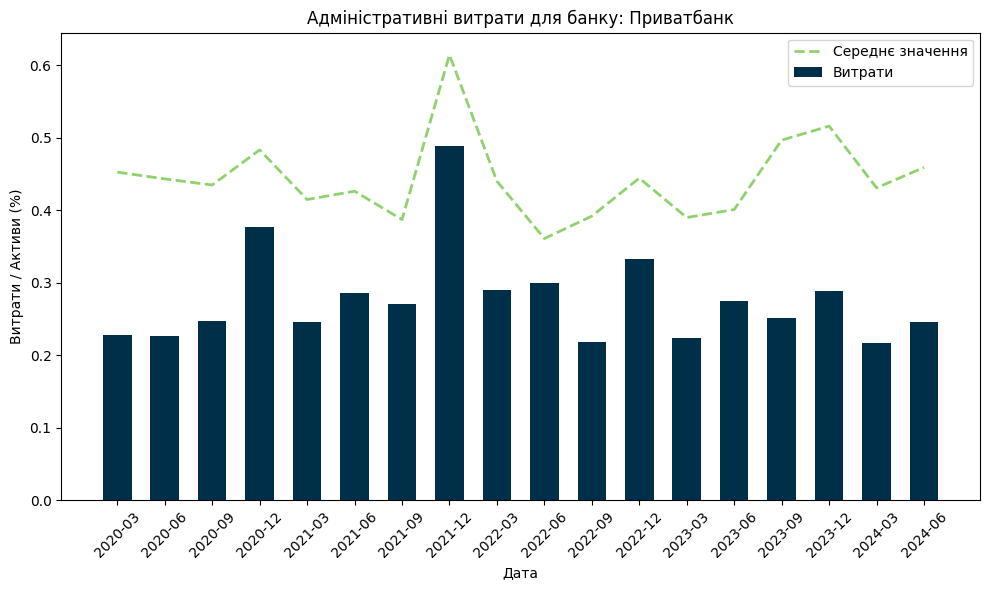

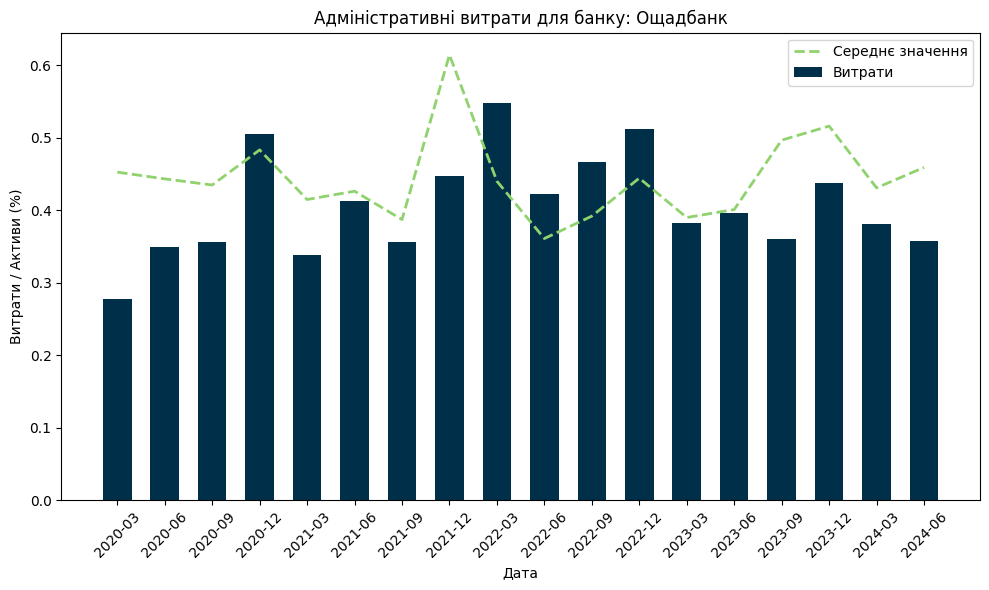

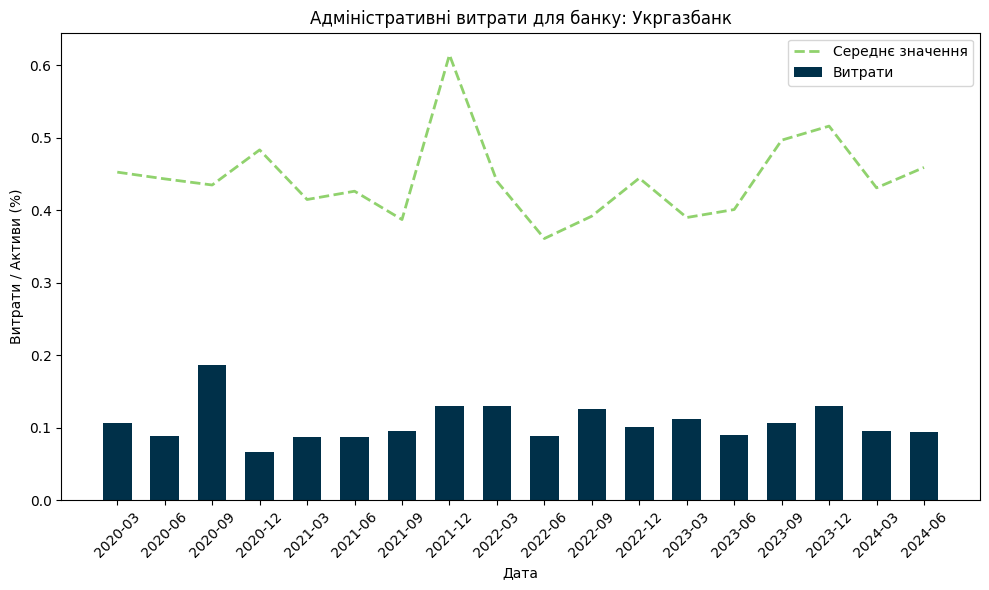

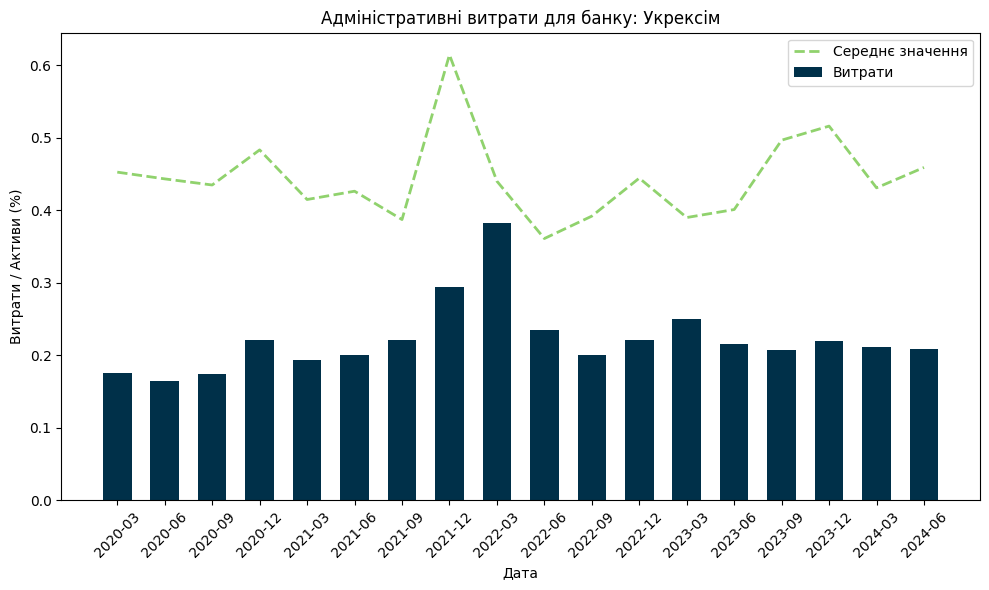

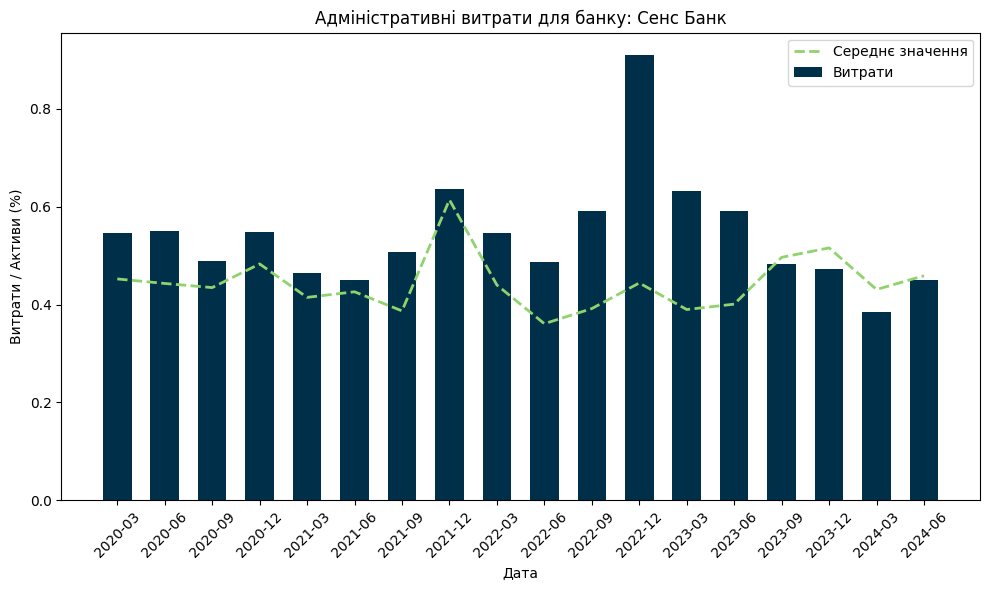

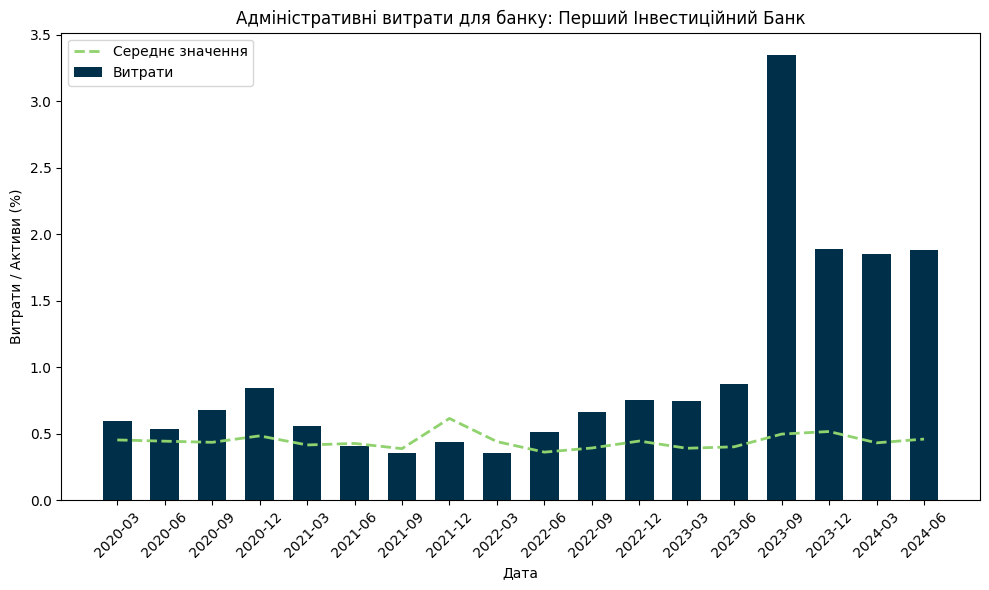

In [6]:
# Load the data
df_expenses_state = pd.read_csv('data/quarterly/administrative_expenses.csv', index_col=0)
df_expenses_private = pd.read_csv('data/quarterly/private_administrative_expenses.csv', index_col=0)

df_assets_state = pd.read_csv('data/quarterly/total_assets.csv', index_col=0)
df_assets_private = pd.read_csv('data/quarterly/private_total_assets.csv', index_col=0)

df_expenses_assets_state = (df_expenses_state / df_assets_state) * 100
df_expenses_assets_private = (df_expenses_private / df_assets_private) * 100

df_combined = pd.concat([df_expenses_assets_state, df_expenses_assets_private], axis=1)
df_combined.reset_index(inplace=True)
df_combined['year_month'] = df_combined['date'].apply(lambda x: x[:7])

banks_ua = ["Приватбанк", "Ощадбанк", "Укргазбанк", "Укрексім", "Сенс Банк", "Перший Інвестиційний Банк"]
# Calculate the average of each row
df_combined['average'] = df_combined.mean(axis=1)

banks = df_expenses_assets_state.columns

# Plotting histograms for each bank
for index, bank in enumerate(banks):
    expenses = df_expenses_assets_state[bank].values
    average = df_combined['average'].values

    months = np.arange(len(expenses))  # Assuming each row represents a month

    plt.figure(figsize=(10, 6))
    plt.bar(df_combined['year_month'], expenses, width=0.6, label='Витрати', align='center', color='#003049')

    # Plot the average line
    plt.plot(months, average, color='#90D26D', label='Середнє значення', linestyle='--', linewidth=2)

    plt.xlabel('Дата')
    plt.ylabel('Витрати / Активи (%)')
    plt.title(f'Адміністративні витрати для банку: {banks_ua[index]}')

    # Customize x-axis ticks to show every half year
    plt.xticks(df_combined['year_month'], rotation=45)

    plt.legend()
    plt.tight_layout()
    plt.show()

Index(['date', 'Державні', 'Приватні', 'Приватбанк'], dtype='object')


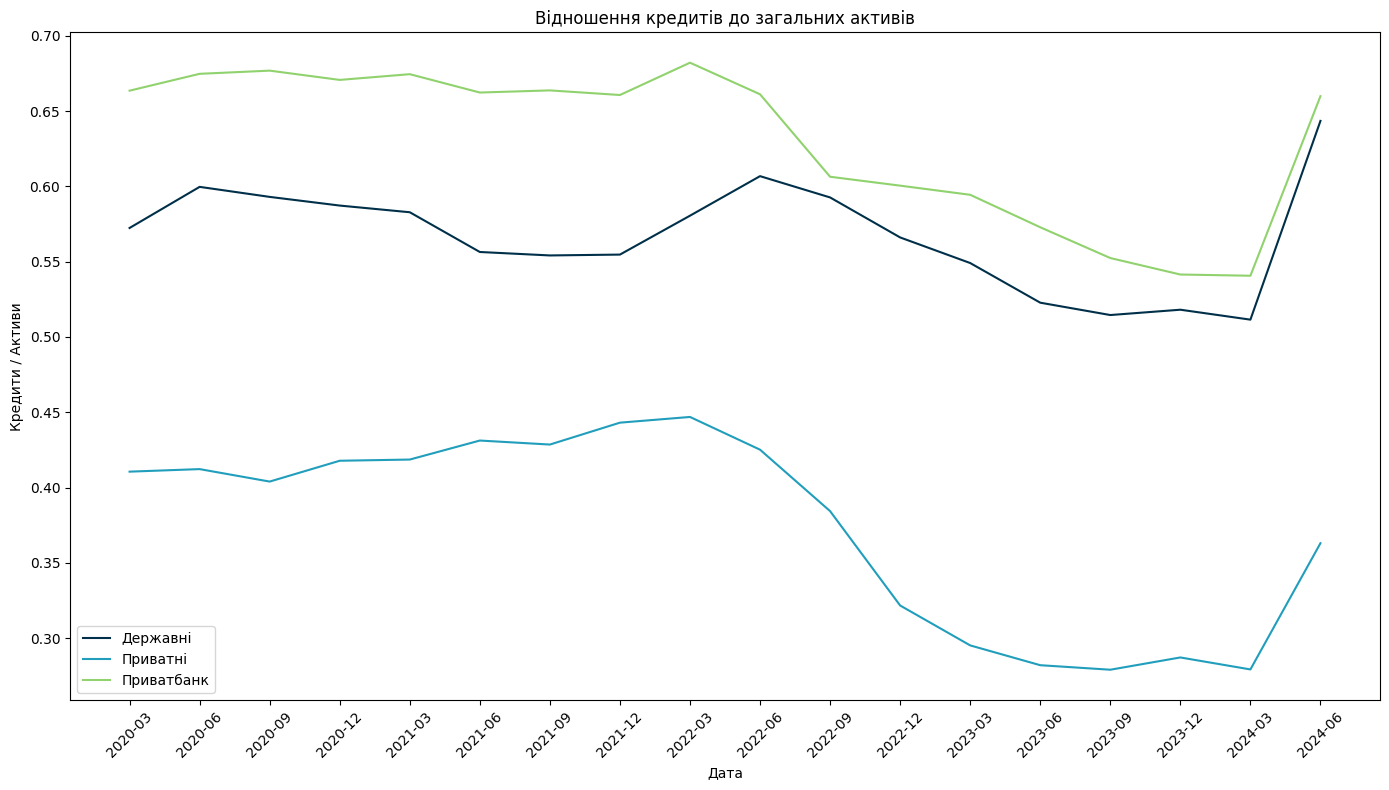

In [7]:
def private_state(private_file, state_file):
    df_state = pd.read_csv(state_file, index_col=0)
    df_private = pd.read_csv(private_file, index_col=0)

    numeric_cols = df_state.select_dtypes(include=np.number).columns.tolist()
    if "privatbank" in df_state.columns:
        df_state['average_state'] = (df_state[numeric_cols].sum(axis=1) - df_state['privatbank']) / 5
    else:
        df_state['average_state'] = (df_state[numeric_cols].sum(axis=1) - df_state['приватбанк']) / 5

    numeric_cols_2 = df_private.select_dtypes(include=np.number).columns.tolist()
    df_private['average_private'] = df_private[numeric_cols_2].sum(axis=1) / 13

    if "privatbank" in df_state.columns:
        df_state_private = pd.DataFrame({
        'Державні': df_state['average_state'],
        'Приватні': df_private['average_private'],
        'Приватбанк': df_state['privatbank']
        })
    else:
        df_state_private = pd.DataFrame({
        'Державні': df_state['average_state'],
        'Приватні': df_private['average_private'],
        'Приватбанк': df_state['приватбанк']
        })
    return df_state_private

df_loans = private_state('data/quarterly/private_loans.csv', 'data/quarterly/loans.csv')
df_iglb = private_state('data/quarterly/private_iglb.csv', 'data/quarterly/iglb.csv')

df_loans = df_loans + df_iglb

df_total_assets = private_state('data/quarterly/private_total_assets.csv', 'data/quarterly/total_assets.csv')

df_loans_assets = (df_loans / df_total_assets)


# Assuming df_loans_assets is already defined and has 'date' as the index
# Reset index to make 'date' a column
df_loans_assets.reset_index(inplace=True)
print(df_loans_assets.columns)

# Extract 'year_month' from 'date'
df_loans_assets['year_month'] = df_loans_assets['date'].apply(lambda x: x[:7])



# Plotting
plt.figure(figsize=(14, 8))

# Colors for the plot
colors = {
    'Державні': '#003049',
    'Приватбанк': '#90D26D',    
    'Приватні': '#219EBC'
}

for bank in df_loans_assets.columns:
    if (bank != 'year_month' and bank != 'date'):
        plt.plot(df_loans_assets['year_month'], df_loans_assets[bank], label=bank.capitalize(), color=colors[bank])

plt.title('Відношення кредитів до загальних активів')
plt.xlabel('Дата')
plt.ylabel('Кредити / Активи')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


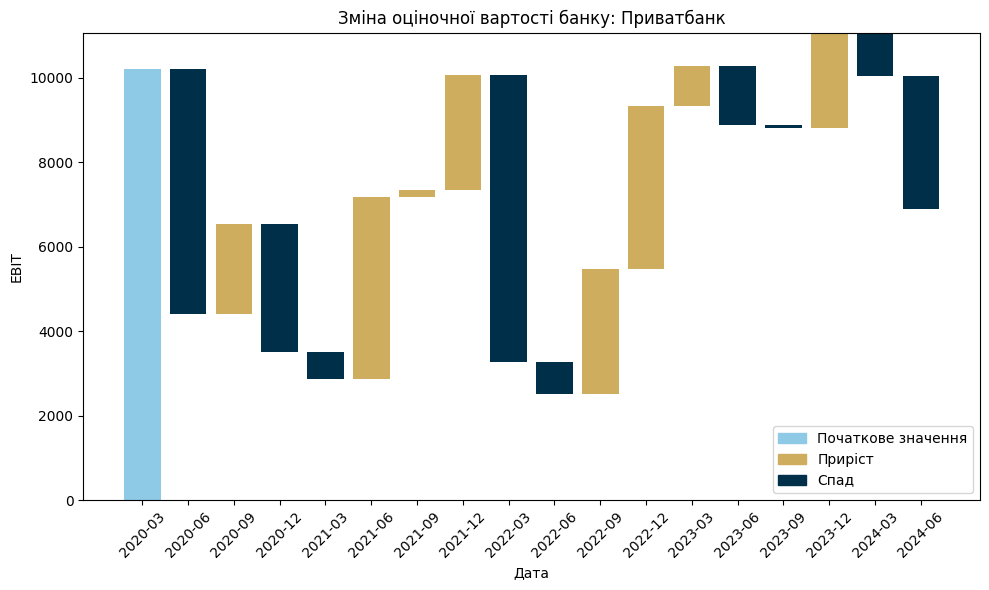

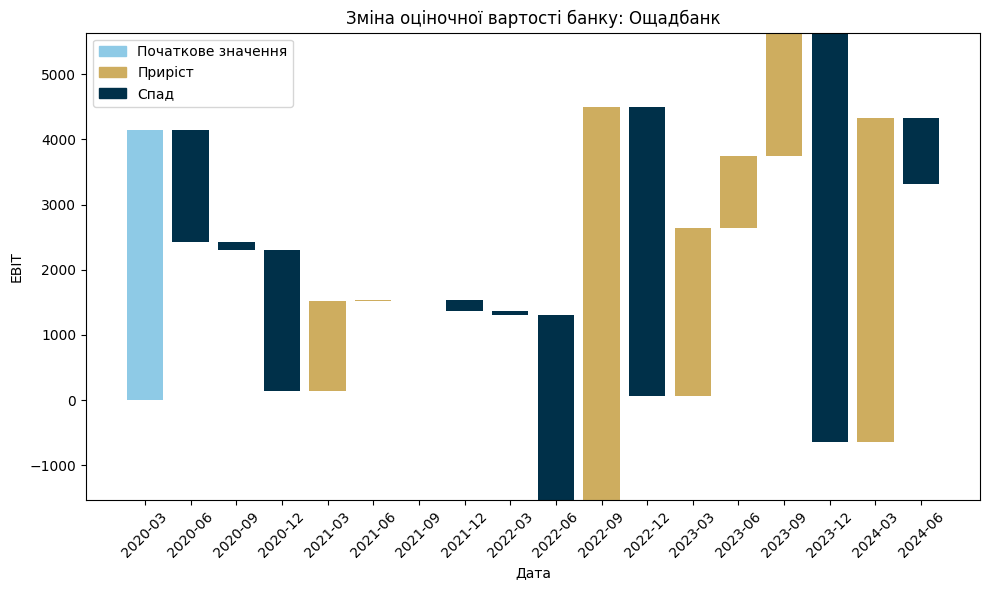

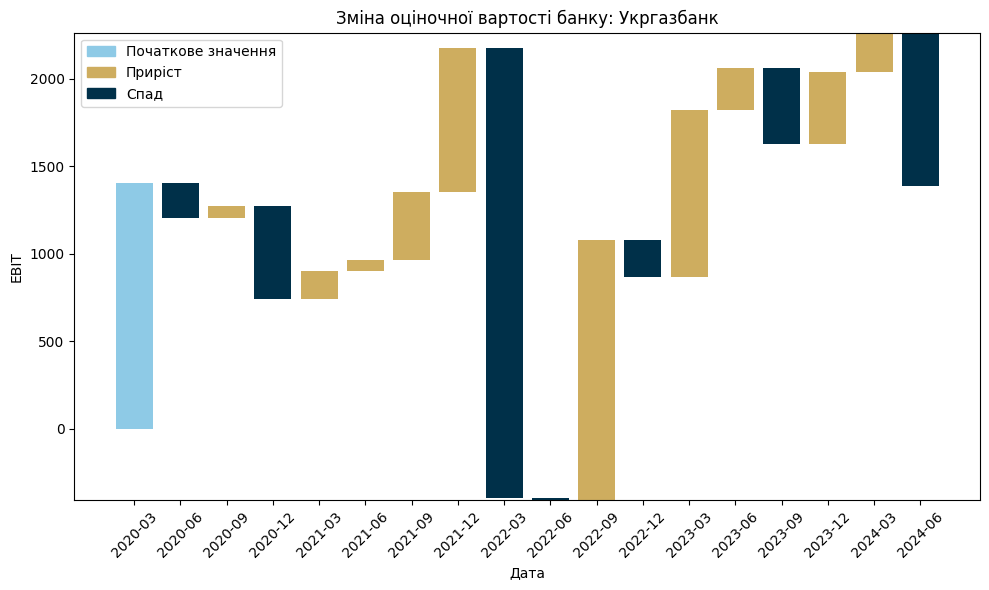

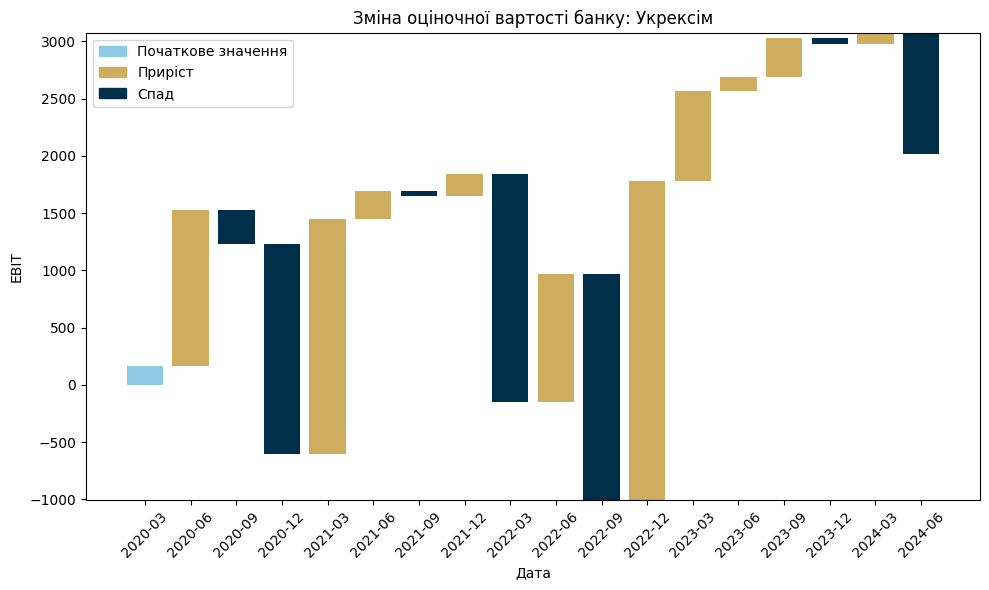

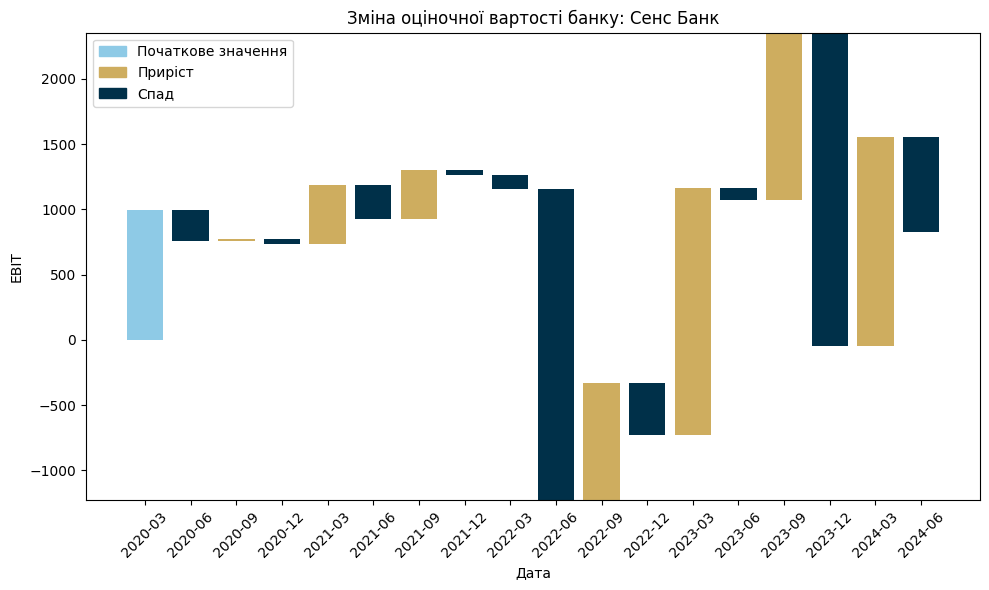

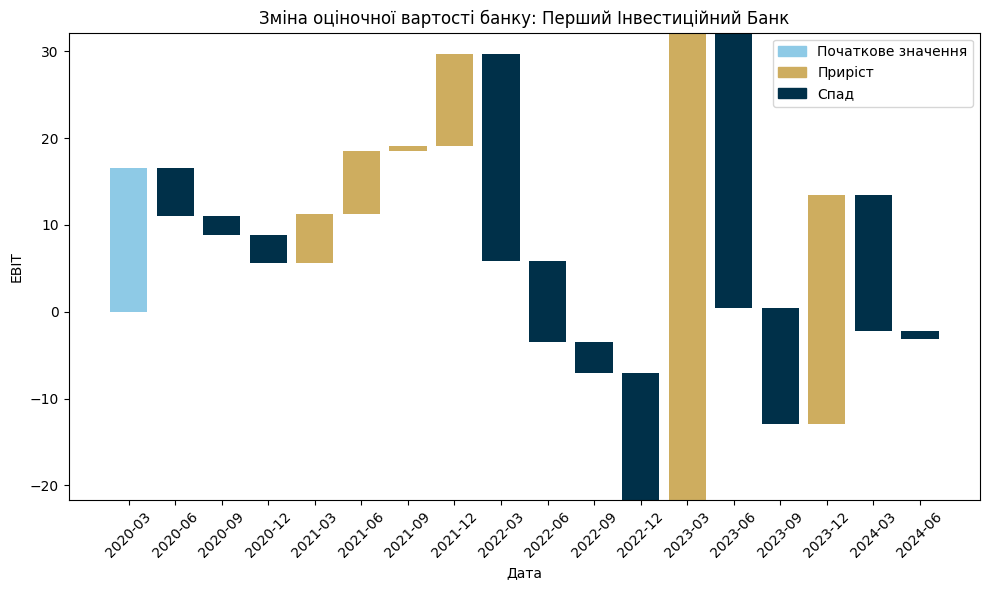

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Load data
banks_ua = ["Приватбанк", "Ощадбанк", "Укргазбанк", "Укрексім", "Сенс Банк", "Перший Інвестиційний Банк"]
df_profit_before_tax = pd.read_csv('data/dollarized_quaterly/profit_before_tax.csv', index_col=0)
df_interest_expenses = pd.read_csv('data/dollarized_quaterly/interest_expenses.csv', index_col=0)
df_ebit = ((df_profit_before_tax + df_interest_expenses) * 17.98) / 1000

# Calculate EBIT difference
df_ebit_diff = df_ebit.diff().fillna(df_ebit)

# List of banks
banks = df_ebit.columns.tolist()

# Function to create waterfall chart
def plot_waterfall(data, labels, title):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Starting point
    x = [labels[0]]
    y = [data[0]]

    for i in range(1, len(data)):
        y.append(data[i])
        x.append(labels[i])
    
    cumulative = 0
    for i in range(len(y)):
        if i == 0:
            plt.bar(x[i], y[i], color='#8ECAE6', label='Початкове значення')
        else:
            plt.bar(x[i], y[i], bottom=cumulative, color='#cead5f' if y[i] > 0 else '#003049', label='Приріст' if y[i] > 0 else 'Спад')
        cumulative += y[i]

    # Create custom legend
    handles = [
        Patch(color='#8ECAE6', label='Початкове значення'),
        Patch(color='#cead5f', label='Приріст'),
        Patch(color='#003049', label='Спад')
    ]
    
    plt.title(title)
    plt.xlabel('Дата')
    plt.ylabel('EBIT')
    plt.xticks(rotation=45)
    plt.legend(handles=handles)
    plt.tight_layout()
    plt.show()

# Create waterfall charts for each bank
for index, bank in enumerate(banks):
    data = df_ebit_diff[bank].tolist()
    labels = [label[:7] for label in df_ebit_diff.index.tolist()]  # Take only the first 7 characters of each label
    plot_waterfall(data, labels, f'Зміна оціночної вартості банку: {banks_ua[index]}')
